## Setup

In [ ]:
JOURNALISM_BIAS_LEXICON = {

    "professional_undermining": {
        "qualifiers": [
            "female executive", "woman entrepreneur", "lady boss", "female CEO",
            "woman leader", "female scientist", "woman engineer", "female doctor",
            "woman journalist", "female reporter", "businesswoman", "career woman",
            "working mother", "female politician", "woman candidate"
        ],
        "diminishing_terms": [
            "trying to", "attempts to", "hopes to", "aims to", "aspires to",
            "wants to be", "dreams of becoming", "wishes to be", "strives to"
        ],
        "surprise_indicators": [
            "surprisingly", "unexpectedly", "despite being", "although a woman",
            "even though", "nonetheless", "however", "managed to", "somehow",
            "against all odds", "defying expectations"
        ]
    },

    "personal_focus": {
        "appearance": [
            "attractive", "beautiful", "pretty", "stunning", "glamorous", "elegant",
            "stylish", "fashionable", "dressed in", "wore", "wearing", "outfit",
            "clothes", "fashion", "style", "looks", "appearance", "slim", "thin",
            "fit", "gorgeous", "lovely", "charming", "graceful"
        ],
        "age_references": [
            "young", "aging", "middle-aged", "mature", "youthful", "-year-old woman",
            "age", "aged", "elderly lady", "senior woman"
        ],
        "family_status": [
            "mother of", "wife of", "married to", "divorced", "single mother",
            "unmarried", "childless", "family obligations", "work-life balance",
            "juggling family", "domestic duties"
        ]
    },

    "emotional_stereotyping": {
        "emotional_framing": [
            "emotional", "passionate", "sensitive", "caring", "nurturing", "soft-spoken",
            "gentle", "kind", "sweet", "loving", "maternal", "sympathetic", "empathetic"
        ],
        "behavior_criticism": [
            "bossy", "aggressive", "pushy", "demanding", "difficult", "complaining",
            "nagging", "hysterical", "dramatic", "temperamental", "moody", "feisty",
            "ambitious", "competitive", "cold", "calculating"
        ],
        "tone_descriptors": [
            "gushed", "complained", "whined", "nagged", "pleaded", "begged",
            "shrieked", "cried", "screamed", "argued", "insisted"
        ]
    },

    "achievement_undermining": {
        "passive_constructions": [
            "was given", "was awarded", "was chosen", "was selected", "was appointed",
            "was named", "was recognized", "was honored", "was promoted"
        ],
        "credit_deflection": [
            "with help from", "guided by", "under the mentorship of", "supported by",
            "assisted by", "following in the footsteps of", "inspired by"
        ],
        "luck_attribution": [
            "lucky", "fortunate", "blessed", "happened to", "chanced upon",
            "fell into", "stumbled into", "wound up"
        ]
    },

    "power_dynamics": {
        "subordinate_framing": [
            "assistant to", "helping", "supporting", "working under", "reports to",
            "answers to", "serves under", "supervised by"
        ],
        "authority_questioning": [
            "self-proclaimed", "so-called", "purported", "supposed", "alleged",
            "claiming to be", "who calls herself", "describes herself as"
        ]
    },

    "voice_suppression": {
        "passive_attribution": [
            "according to", "claims", "states", "believes", "feels", "thinks",
            "suggests", "proposes", "indicates"
        ],
        "credibility_undermining": [
            "emotional argument", "personal opinion", "personal view",
            "based on feelings", "subjective perspective"
        ]
    },

    "intersectional_bias": {
        "race_gender": [
            "minority woman", "woman of color", "ethnic woman", "diverse candidate",
            "exotic", "foreign"
        ],
        "class_gender": [
            "privileged background", "wealthy family", "elite education",
            "humble beginnings", "modest background"
        ]
    }
}

In [ ]:
import spacy
import pandas as pd
import numpy as np
from collections import defaultdict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Change current working directory to Project folder in GDrive
os.chdir("/content/drive/MyDrive/Google Colab Projects/gender-bias")

Mounted at /content/drive


## Data Pre-processing

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt_tab')


def preprocess_text(text):
    """
    Comprehensive text preprocessing including tokenization, lemmatization,
    stopword removal, and cleaning.

    Args:
        text (str): Raw input text
    Returns:
        str: Preprocessed text
    """
    # Download required NLTK data
    try:
        nltk.data.find('tokenizers/punkt')
        nltk.data.find('corpora/stopwords')
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('punkt')
        nltk.download('stopwords')
        nltk.download('wordnet')
        nltk.download('averaged_perceptron_tagger')  # needed for lemmatization

    def clean_text(text):
        """Initial cleaning of text"""
        if not isinstance(text, str):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        return text

    # Initialize lemmatizer and get stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    try:
        # Initial cleaning
        text = clean_text(text)

        # Tokenization
        tokens = word_tokenize(text)

        # Lemmatization and stopword removal in one pass
        # Only keep tokens that:
        # 1. Are not stop words
        # 2. Are longer than 2 characters
        # 3. Contain only letters
        tokens = [lemmatizer.lemmatize(token) for token in tokens
                 if token not in stop_words
                 and len(token) > 2
                 and token.isalpha()]

        # Join tokens back into text
        processed_text = ' '.join(tokens)

        return processed_text

    except Exception as e:
        print(f"Error in preprocessing: {str(e)}")
        return ""





[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Lexical Analysis

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import re

class JournalismBiasLabeler:
    def __init__(self, lexicon):
        self.lexicon = lexicon
        self.nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

        # Store category keys for consistency
        self.categories = list(lexicon.keys())

        # Precompile patterns
        self.patterns = {}
        for category, subcategories in lexicon.items():
            self.patterns[category] = {}
            for subcategory, terms in subcategories.items():
                pattern = '|'.join(r'\b{}\b'.format(re.escape(term)) for term in terms)
                self.patterns[category][subcategory] = re.compile(pattern, re.IGNORECASE)

    def analyze_text(self, text):
        if not isinstance(text, str) or not text.strip():
            return {cat: 0.0 for cat in self.categories}

        text = text.lower()
        scores = defaultdict(float)

        # Process all patterns
        for category, subcategory_patterns in self.patterns.items():
            category_score = 0
            for subcategory, pattern in subcategory_patterns.items():
                matches = len(pattern.findall(text))
                if matches > 0:
                    if category == 'professional_undermining':
                        category_score += matches
                    elif category == 'personal_focus':
                        category_score += matches * 0.5
                    elif category == 'emotional_stereotyping':
                        category_score += matches * 0.7
                    else:
                        category_score += matches

            scores[category] = category_score

        return dict(scores)

    def calculate_bias_score(self, scores):
        # Ensure weights match lexicon categories
        weights = {
            'professional_undermining': 0.25,
            'personal_focus': 0.2,
            'emotional_stereotyping': 0.15,
            'achievement_undermining': 0.15,
            'power_dynamics': 0.15,
            'voice_suppression': 0.1
        }

        weighted_score = sum(scores.get(category, 0) * weights.get(category, 0.1)
                           for category in self.categories)
        return min(1.0, weighted_score / 3.0)

def create_labels(df, threshold=0.3, batch_size=100):
    labeler = JournalismBiasLabeler(JOURNALISM_BIAS_LEXICON)
    labels = []
    detailed_scores = []

    # Process in batches
    for i in tqdm(range(0, len(df), batch_size), desc="Processing articles"):
        batch = df['text'].iloc[i:i+batch_size]
        batch_scores = [labeler.analyze_text(str(text)) for text in batch]
        batch_labels = [1 if labeler.calculate_bias_score(scores) >= threshold else 0
                       for scores in batch_scores]

        labels.extend(batch_labels)
        detailed_scores.extend(batch_scores)

    # Add scores to DataFrame
    for category in labeler.categories:
        df[f'bias_score_{category}'] = [scores[category] for scores in detailed_scores]

    df['overall_bias_score'] = [labeler.calculate_bias_score(scores) for scores in detailed_scores]

    return np.array(labels)

def analyze_bias_distribution(df):
    bias_columns = [col for col in df.columns if col.startswith('bias_score_')]

    print("Bias Score Distribution:")
    for col in bias_columns:
        if col != 'overall_bias_score':
            print(f"\n{col.replace('bias_score_', '').replace('_', ' ').title()}:")
            print(f"Mean: {df[col].mean():.3f}")
            print(f"Median: {df[col].median():.3f}")
            print(f"Articles with this bias: {(df[col] > 0).sum()}")

    print("\nOverall Bias Distribution:")
    print(f"Mean Score: {df['overall_bias_score'].mean():.3f}")
    print(f"Biased Articles: {(df['overall_bias_score'] >= 0.3).sum()}")
    print(f"Total Articles: {len(df)}")

def main():
    try:
        print("Loading dataset...")
        df = pd.read_csv('combined_articles.csv')

        print("Pre-processing data")
        preprocess_text(df.text)

        print("Creating labels...")
        labels = create_labels(df)

        print("Analyzing bias distribution...")
        analyze_bias_distribution(df)

        print("\nSaving results...")
        df.to_csv('articles_with_bias_scores.csv', index=False)
        print("Results saved to 'articles_with_bias_scores.csv'")

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()

Loading dataset...
Pre-processing data


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Creating labels...


Processing articles: 100%|██████████| 530/530 [06:09<00:00,  1.44it/s]


Analyzing bias distribution...
Bias Score Distribution:

Professional Undermining:
Mean: 0.360
Median: 0.000
Articles with this bias: 11921

Personal Focus:
Mean: 0.281
Median: 0.000
Articles with this bias: 12637

Emotional Stereotyping:
Mean: 0.276
Median: 0.000
Articles with this bias: 11862

Achievement Undermining:
Mean: 0.092
Median: 0.000
Articles with this bias: 3603

Power Dynamics:
Mean: 0.174
Median: 0.000
Articles with this bias: 6339

Voice Suppression:
Mean: 0.661
Median: 0.000
Articles with this bias: 16111

Intersectional Bias:
Mean: 0.071
Median: 0.000
Articles with this bias: 2122

Overall Bias Distribution:
Mean Score: 0.098
Biased Articles: 4598
Total Articles: 53000

Saving results...
Results saved to 'articles_with_bias_scores.csv'


## Model Training

Training classification system...
Training Random Forest on category scores...
Training SVM on text features...

Category Feature Importance:
                               feature  importance
0  bias_score_professional_undermining    0.333523
1            bias_score_personal_focus    0.210369
5         bias_score_voice_suppression    0.191201
2    bias_score_emotional_stereotyping    0.132823
4            bias_score_power_dynamics    0.076094
3   bias_score_achievement_undermining    0.034868
6       bias_score_intersectional_bias    0.021122


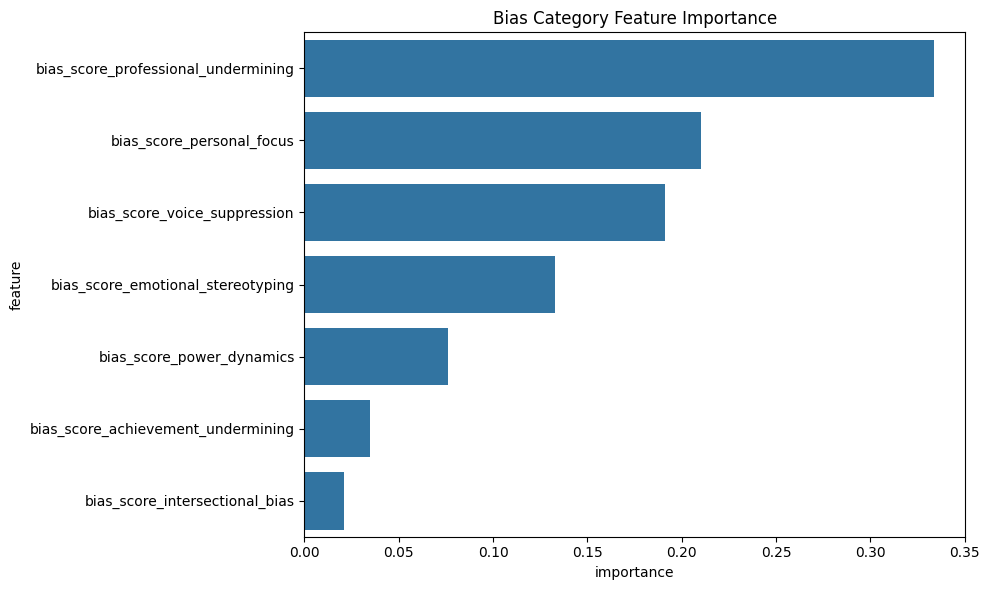


Model Performance:

Text Classifier (SVM):
accuracy: 0.940 ± 0.001
precision: 0.744 ± 0.010
recall: 0.485 ± 0.012
f1: 0.587 ± 0.008

Category Classifier (Random Forest):
accuracy: 0.994 ± 0.001
precision: 0.956 ± 0.004
recall: 0.977 ± 0.007
f1: 0.967 ± 0.004

Sample Prediction:
Prediction: Unbiased
Overall Confidence: 0.998
Text Analysis Confidence: 0.997
Category Analysis Confidence: 1.000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [6]:
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


class BiasClassificationSystem:
    def __init__(self):
        # Text vectorizer for article content
        self.text_vectorizer = TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            strip_accents='unicode',
            min_df=2,
            max_df=0.95
        )

        with open('tfidf_vectorizer.pkl', 'wb') as f:
          pickle.dump(self.text_vectorizer, f)

        # Random Forest for category scores
        self.category_classifier = RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_split=4,
            min_samples_leaf=2,
            max_features='sqrt',
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        )

        # SVM for text content
        self.text_classifier = CalibratedClassifierCV(
            LinearSVC(
                C=1.0,
                class_weight='balanced',
                dual=False,
                max_iter=1000,
                random_state=42
            )
        )

        self.scaler = StandardScaler()

    def prepare_features(self, df):
        """Prepare both text and category score features"""
        # Get bias category score columns
        category_columns = [col for col in df.columns
                          if col.startswith('bias_score_')
                          and col != 'bias_score_overall']

        # Text features
        text_features = self.text_vectorizer.fit_transform(df['text'])

        # Category score features
        category_features = self.scaler.fit_transform(df[category_columns])

        return text_features, category_features, category_columns

    def train(self, df, labels):
        """Train both classifiers"""
        # Prepare features
        text_features, category_features, self.category_columns = self.prepare_features(df)

        # Train category classifier
        print("Training Random Forest on category scores...")
        self.category_classifier.fit(category_features, labels)

        # Train text classifier
        print("Training SVM on text features...")
        self.text_classifier.fit(text_features, labels)

        # Analyze feature importance
        self._analyze_feature_importance(category_features, text_features)

        # Evaluate models
        self._evaluate_models(text_features, category_features, labels)

    def predict(self, text, category_scores):
        """Make predictions using both classifiers"""
        # Transform features
        text_features = self.text_vectorizer.transform([text])
        category_features = self.scaler.transform([category_scores])

        # Get predictions and probabilities
        text_prob = self.text_classifier.predict_proba(text_features)[0]
        category_prob = self.category_classifier.predict_proba(category_features)[0]

        # Weighted combination (can be adjusted based on model performance)
        final_prob = 0.6 * text_prob + 0.4 * category_prob

        return {
            'prediction': int(final_prob[1] > 0.5),
            'confidence': float(max(final_prob)),
            'text_confidence': float(max(text_prob)),
            'category_confidence': float(max(category_prob))
        }

    def _analyze_feature_importance(self, category_features, text_features):
        """Analyze and visualize feature importance"""
        # Category feature importance
        category_importance = pd.DataFrame({
            'feature': self.category_columns,
            'importance': self.category_classifier.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nCategory Feature Importance:")
        print(category_importance)

        # Visualize
        plt.figure(figsize=(10, 6))
        sns.barplot(data=category_importance, x='importance', y='feature')
        plt.title('Bias Category Feature Importance')
        plt.tight_layout()
        plt.show()

    def _evaluate_models(self, text_features, category_features, labels):
        """Evaluate both models with cross-validation"""
        # Evaluate text classifier
        text_scores = cross_validate(
            self.text_classifier, text_features, labels,
            scoring=['accuracy', 'precision', 'recall', 'f1'],
            cv=5
        )

        # Evaluate category classifier
        category_scores = cross_validate(
            self.category_classifier, category_features, labels,
            scoring=['accuracy', 'precision', 'recall', 'f1'],
            cv=5
        )

        print("\nModel Performance:")
        print("\nText Classifier (SVM):")
        for metric, scores in text_scores.items():
            if metric.startswith('test_'):
                print(f"{metric[5:]}: {scores.mean():.3f} ± {scores.std():.3f}")

        print("\nCategory Classifier (Random Forest):")
        for metric, scores in category_scores.items():
            if metric.startswith('test_'):
                print(f"{metric[5:]}: {scores.mean():.3f} ± {scores.std():.3f}")

def main():
    # Load data
    df = pd.read_csv('articles_with_bias_scores.csv')

    # Create classifier system
    bias_classifier = BiasClassificationSystem()
    # Save the trained classifier
    with open('bias_classifier.pkl', 'wb') as f:
      pickle.dump(bias_classifier, f)

    # Split data
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # Train system
    print("Training classification system...")
    bias_classifier.train(train_df, train_df['overall_bias_score'] >= 0.3)

    # Example prediction
    sample_text = test_df['text'].iloc[0]
    sample_scores = test_df[[col for col in test_df.columns
                            if col.startswith('bias_score_')
                            and col != 'bias_score_overall']].iloc[0].to_dict()

    result = bias_classifier.predict(sample_text, list(sample_scores.values()))

    print("\nSample Prediction:")
    print(f"Prediction: {'Biased' if result['prediction'] else 'Unbiased'}")
    print(f"Overall Confidence: {result['confidence']:.3f}")
    print(f"Text Analysis Confidence: {result['text_confidence']:.3f}")
    print(f"Category Analysis Confidence: {result['category_confidence']:.3f}")

if __name__ == "__main__":
    main()

Plotting category distribution...


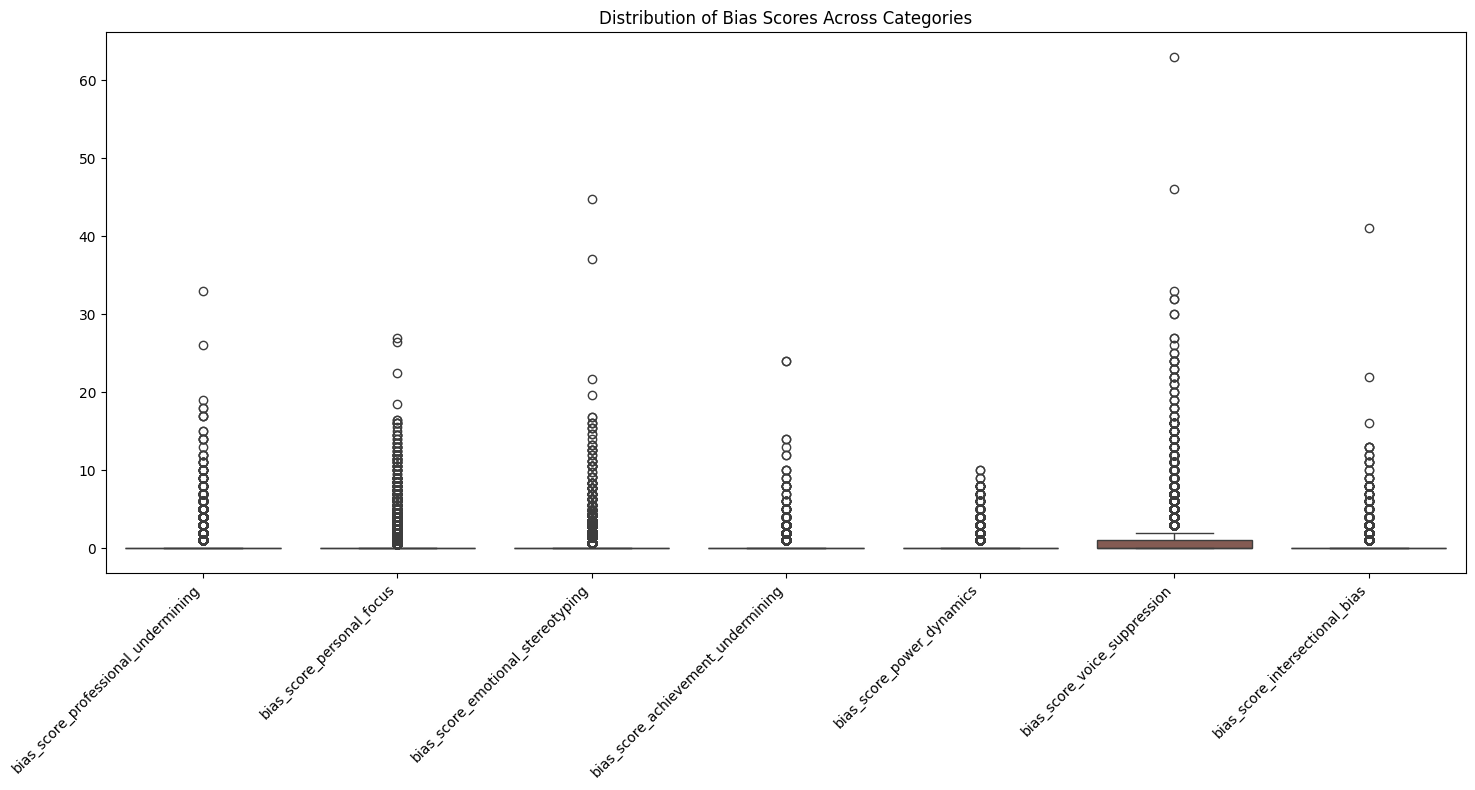


Category-wise Statistics:
       bias_score_professional_undermining  bias_score_personal_focus  \
count                         53000.000000               53000.000000   
mean                              0.359717                   0.280840   
std                               0.895268                   0.849976   
min                               0.000000                   0.000000   
25%                               0.000000                   0.000000   
50%                               0.000000                   0.000000   
75%                               0.000000                   0.000000   
max                              33.000000                  27.000000   

       bias_score_emotional_stereotyping  bias_score_achievement_undermining  \
count                       53000.000000                        53000.000000   
mean                            0.276236                            0.092208   
std                             0.786035                            0.44311

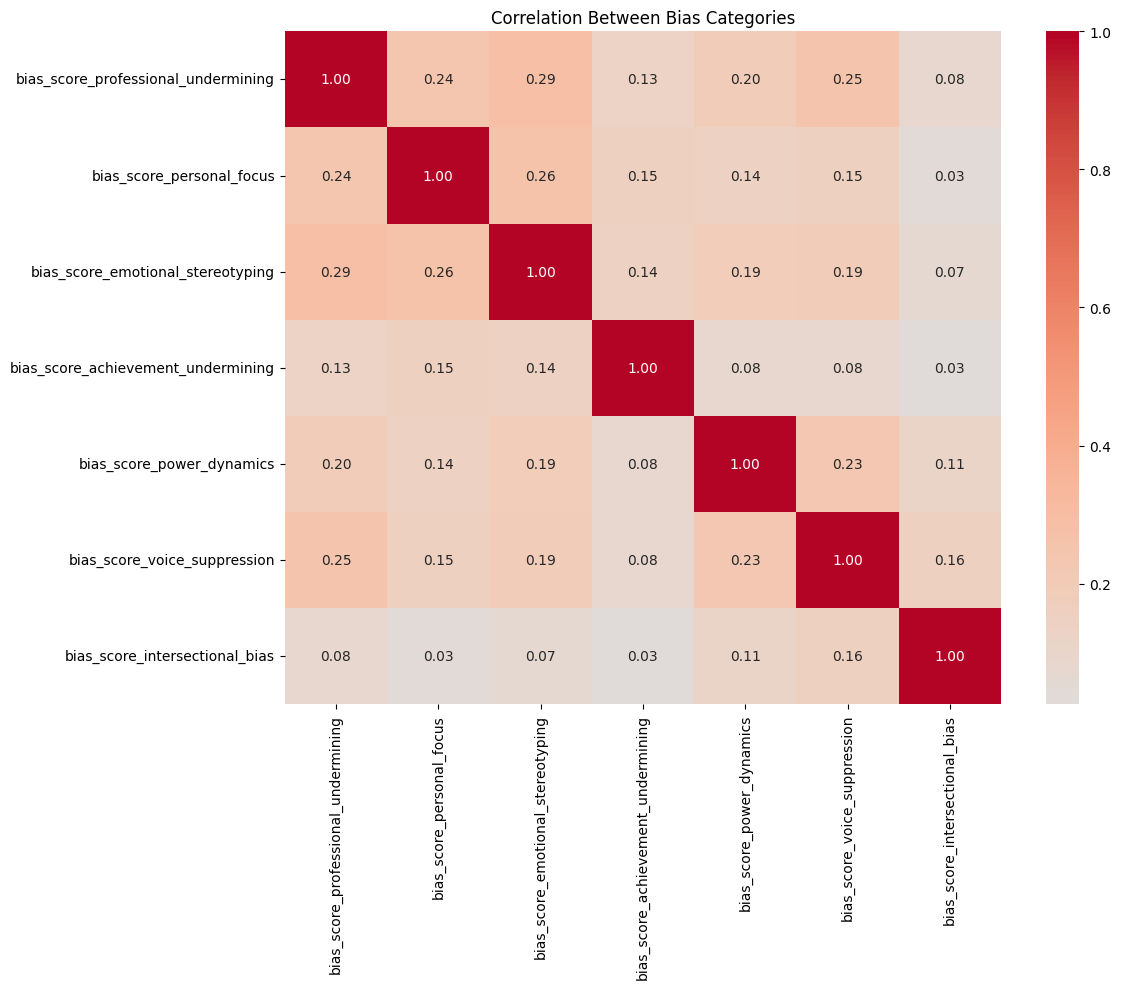


Plotting category impact...


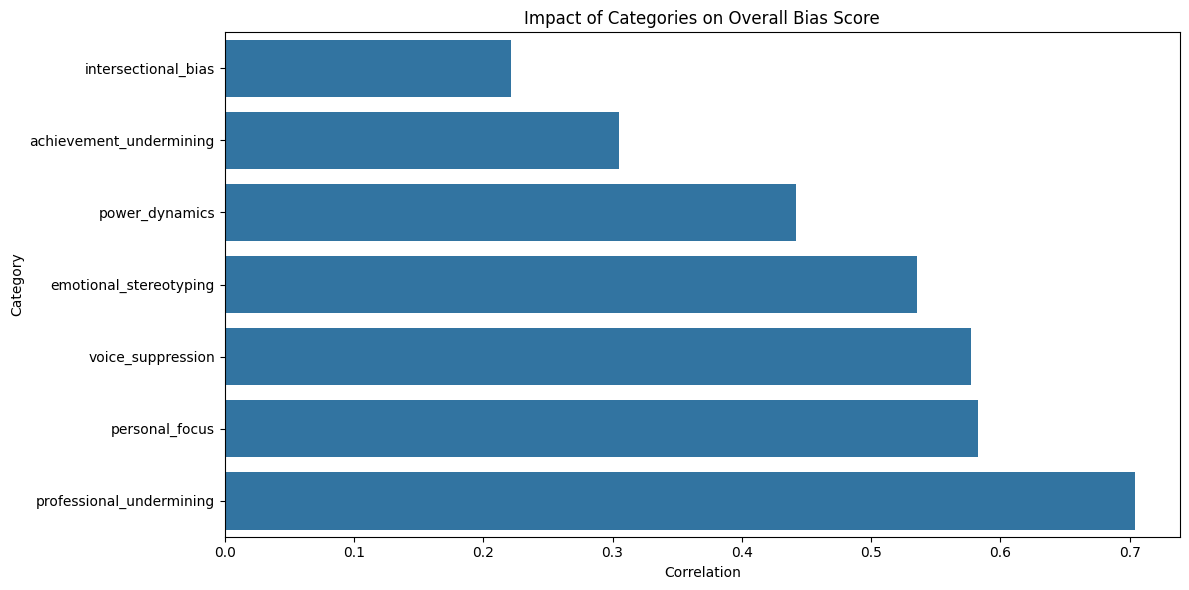


Plotting category composition...


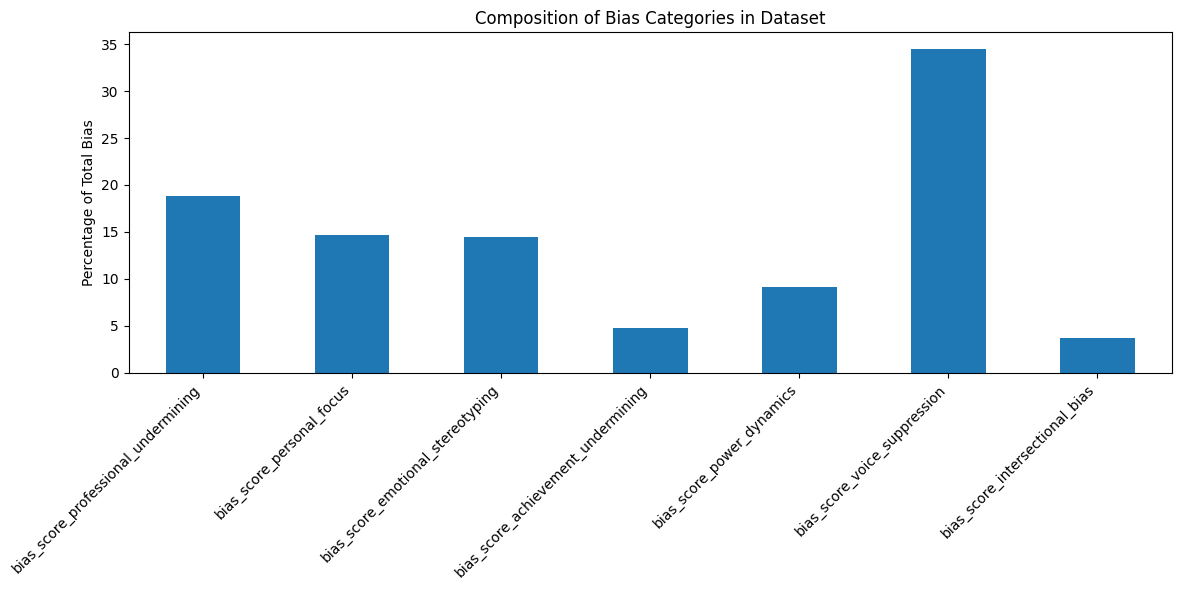


Plotting category trends...


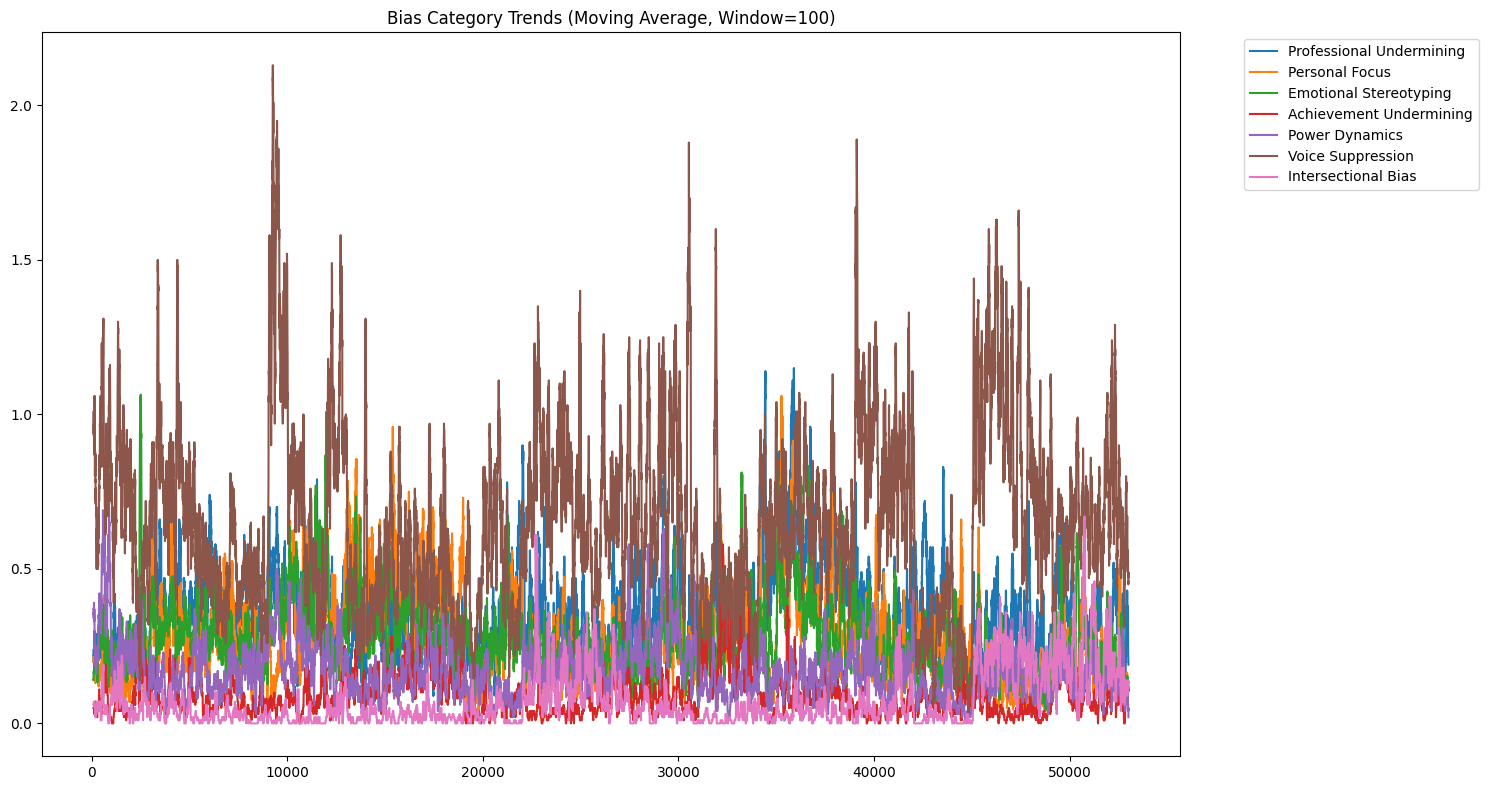


Generating interactive scatter plot...


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class BiasVisualizer:
    def __init__(self, df):
        self.df = df
        self.bias_columns = [col for col in df.columns
                           if col.startswith('bias_score_')
                           and col != 'overall_bias_score']

    def plot_category_distribution(self):
        """Plot distribution of bias scores across categories"""
        plt.figure(figsize=(15, 8))

        # Create box plot
        sns.boxplot(data=self.df[self.bias_columns])
        plt.xticks(rotation=45, ha='right')
        plt.title('Distribution of Bias Scores Across Categories')
        plt.tight_layout()
        plt.show()

        # Show summary statistics
        stats = self.df[self.bias_columns].describe()
        print("\nCategory-wise Statistics:")
        print(stats)

    def plot_category_correlation(self):
        """Plot correlation matrix between different bias categories"""
        plt.figure(figsize=(12, 10))
        correlation = self.df[self.bias_columns].corr()

        # Create heatmap
        sns.heatmap(correlation,
                   annot=True,
                   cmap='coolwarm',
                   center=0,
                   fmt='.2f')
        plt.title('Correlation Between Bias Categories')
        plt.tight_layout()
        plt.show()

    def plot_category_impact(self):
        """Plot impact of each category on overall bias score"""
        # Calculate correlation with overall score
        correlations = []
        for col in self.bias_columns:
            corr = self.df[col].corr(self.df['overall_bias_score'])
            correlations.append({'Category': col.replace('bias_score_', ''),
                               'Correlation': corr})

        corr_df = pd.DataFrame(correlations)
        corr_df = corr_df.sort_values('Correlation', ascending=True)

        plt.figure(figsize=(12, 6))
        sns.barplot(data=corr_df, x='Correlation', y='Category')
        plt.title('Impact of Categories on Overall Bias Score')
        plt.tight_layout()
        plt.show()

    def plot_interactive_scatter(self):
        """Create interactive scatter plot comparing categories"""
        # Create scatter matrix using plotly
        fig = px.scatter_matrix(
            self.df,
            dimensions=self.bias_columns,
            color='overall_bias_score',
            title='Interactive Comparison of Bias Categories'
        )
        fig.show()

    def plot_category_trends(self):
        """Plot trends of bias categories over articles"""
        # Calculate moving averages
        window_size = 100
        rolling_means = self.df[self.bias_columns].rolling(window=window_size).mean()

        plt.figure(figsize=(15, 8))
        for col in self.bias_columns:
            plt.plot(rolling_means[col],
                    label=col.replace('bias_score_', '').replace('_', ' ').title())

        plt.title(f'Bias Category Trends (Moving Average, Window={window_size})')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def plot_category_composition(self):
        """Plot stacked bar chart showing bias composition"""
        # Calculate proportion of each category
        category_sums = self.df[self.bias_columns].sum()
        total = category_sums.sum()
        proportions = category_sums / total * 100

        plt.figure(figsize=(12, 6))
        proportions.plot(kind='bar')
        plt.title('Composition of Bias Categories in Dataset')
        plt.ylabel('Percentage of Total Bias')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def plot_all_visualizations(self):
        """Generate all visualizations"""
        print("Plotting category distribution...")
        self.plot_category_distribution()

        print("\nPlotting category correlation...")
        self.plot_category_correlation()

        print("\nPlotting category impact...")
        self.plot_category_impact()

        print("\nPlotting category composition...")
        self.plot_category_composition()

        print("\nPlotting category trends...")
        self.plot_category_trends()

        print("\nGenerating interactive scatter plot...")
        self.plot_interactive_scatter()

# Example usage
def main():
    # Load data
    df = pd.read_csv('articles_with_bias_scores.csv')

    # Create visualizer
    visualizer = BiasVisualizer(df)

    # Generate all visualizations
    visualizer.plot_all_visualizations()

if __name__ == "__main__":
    main()

Generating bias distribution plot...


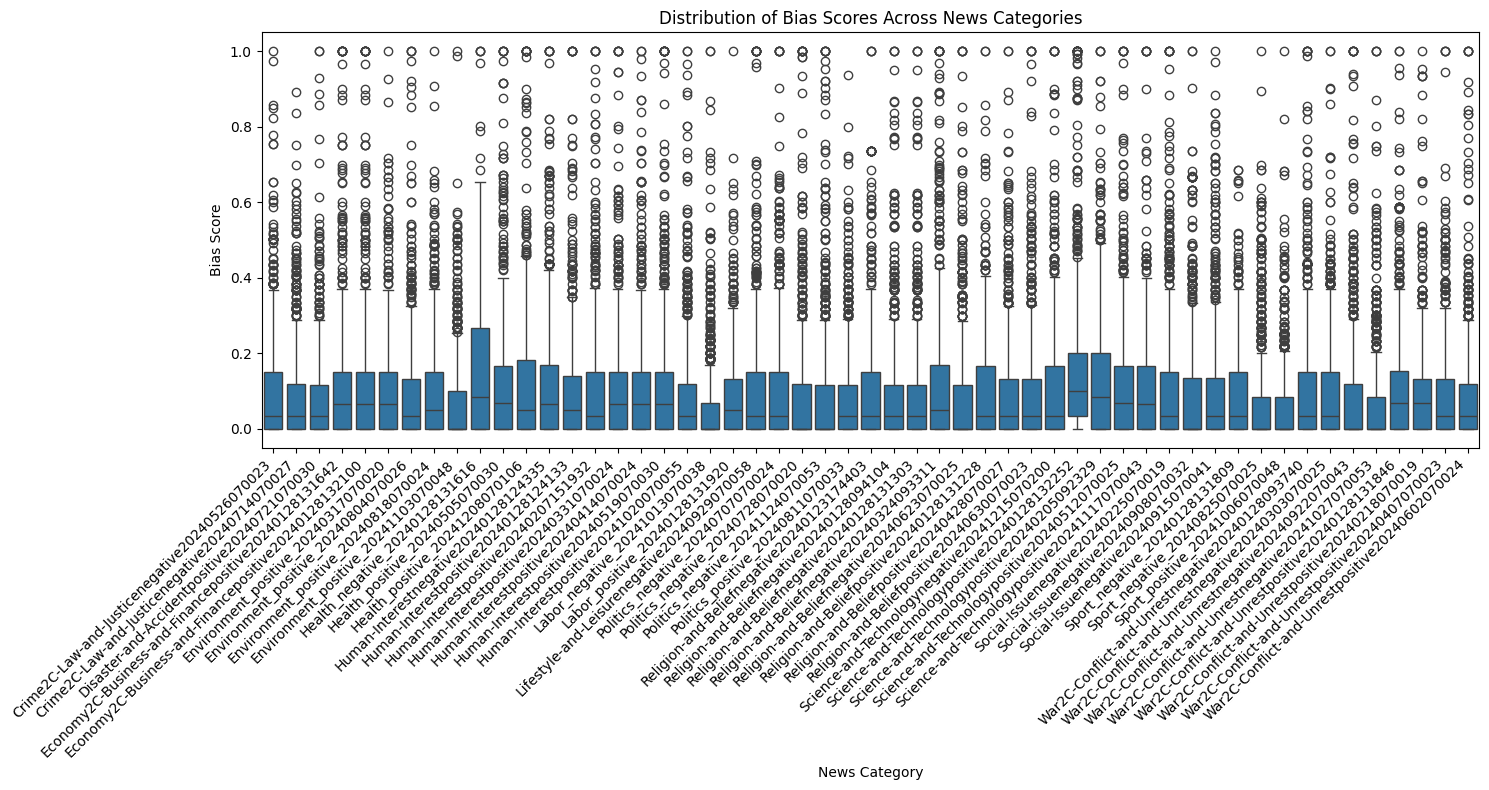


Bias Statistics by Category:
                                                     mean    std  count
category                                                               
Science-and-Technologypositive20240128132252        0.156  0.202   1000
Health_negative_20240128131616                      0.138  0.152   1000
Science-and-Technologypositive20240205092329        0.134  0.159   1000
Religion-and-Beliefnegative20240324093311           0.124  0.183   1000
Health_positive_20240505070030                      0.121  0.163   1000
Health_positive_20241208070106                      0.120  0.170   1000
Human-Interestnegative20240128124335                0.118  0.165   1000
Science-and-Technologypositive20240512070025        0.115  0.153   1000
Economy2C-Business-and-Financepositive202401281...  0.113  0.158   1000
Economy2C-Business-and-Financepositive202401281...  0.113  0.158   1000
Human-Interestpositive20240519070030                0.111  0.162   1000
Human-Interestpositive202403310700

<ipython-input-11-0f6ca74b0086>:77: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



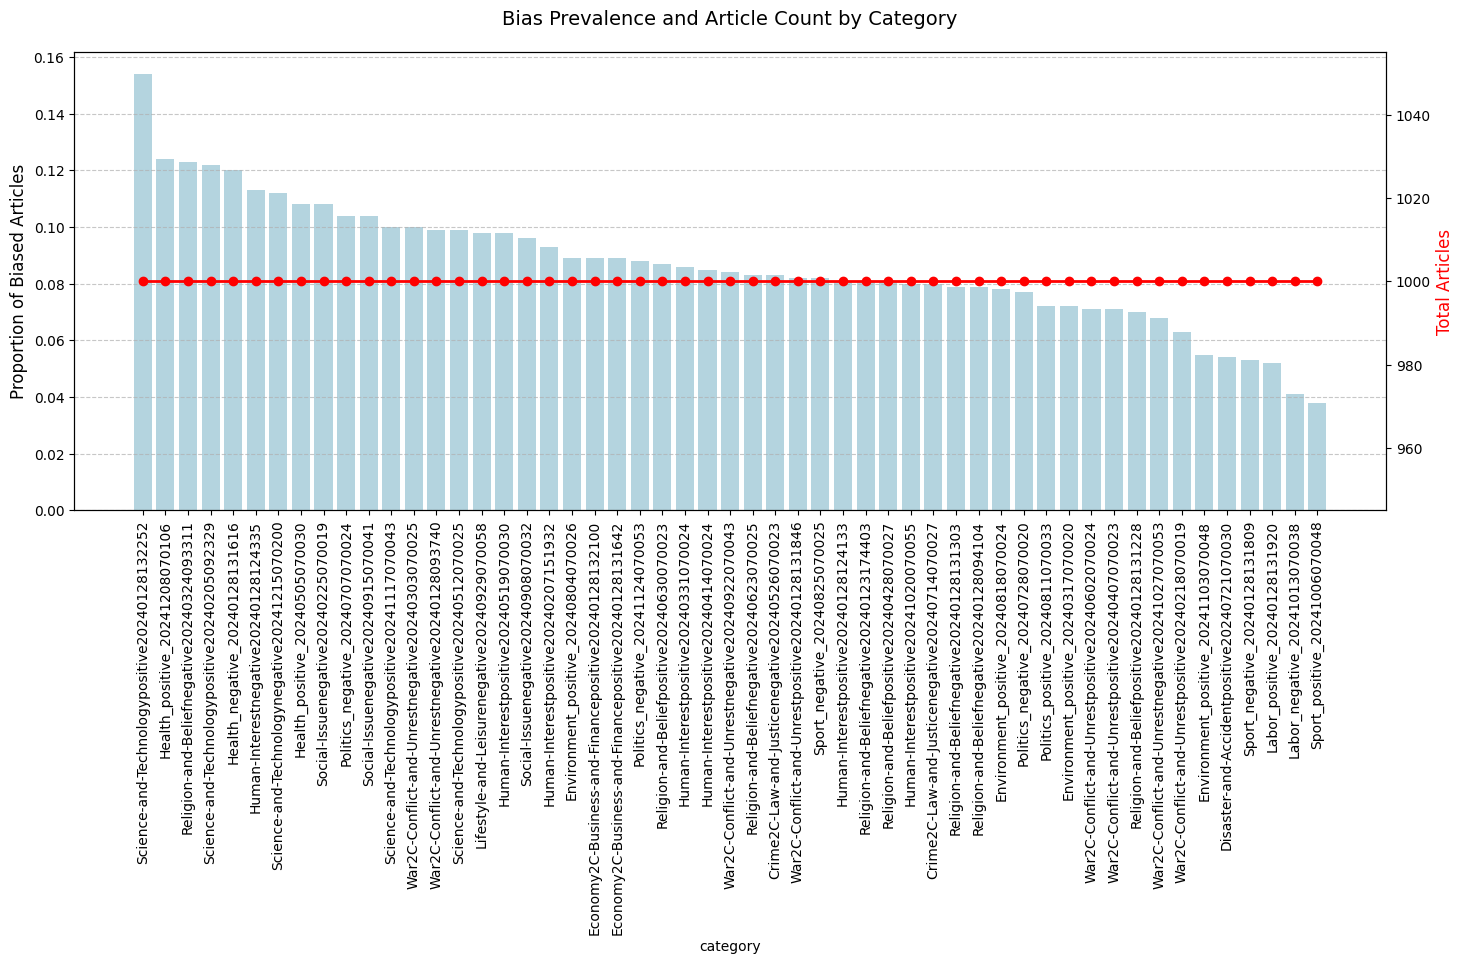


Generating category heatmap...


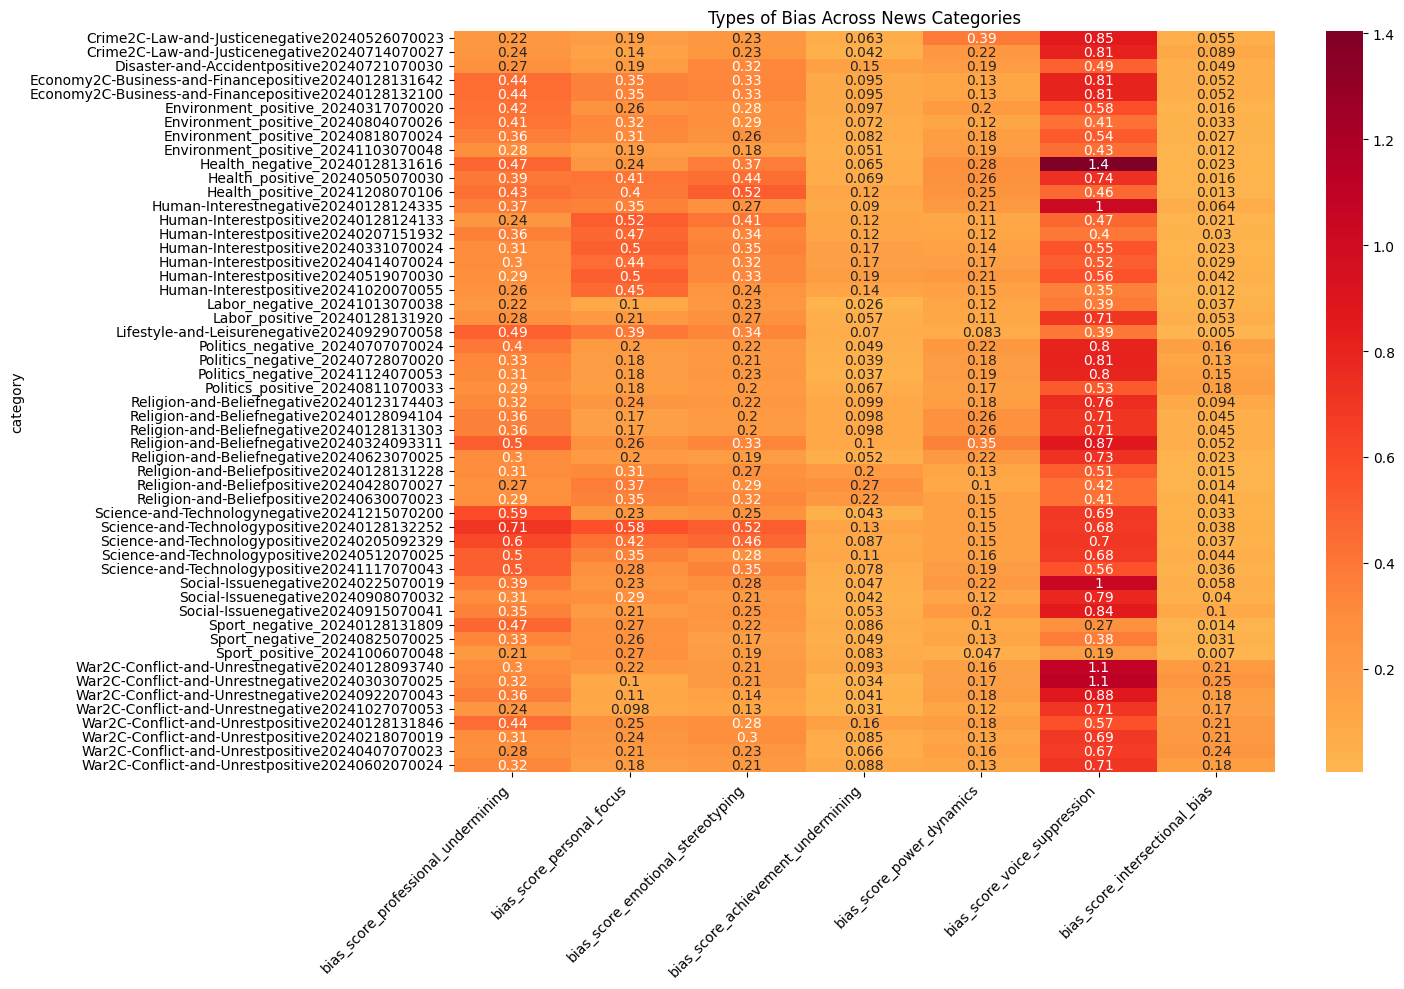


Generating bias trends plot...


<ipython-input-11-0f6ca74b0086>:119: FutureWarning:

In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`

/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



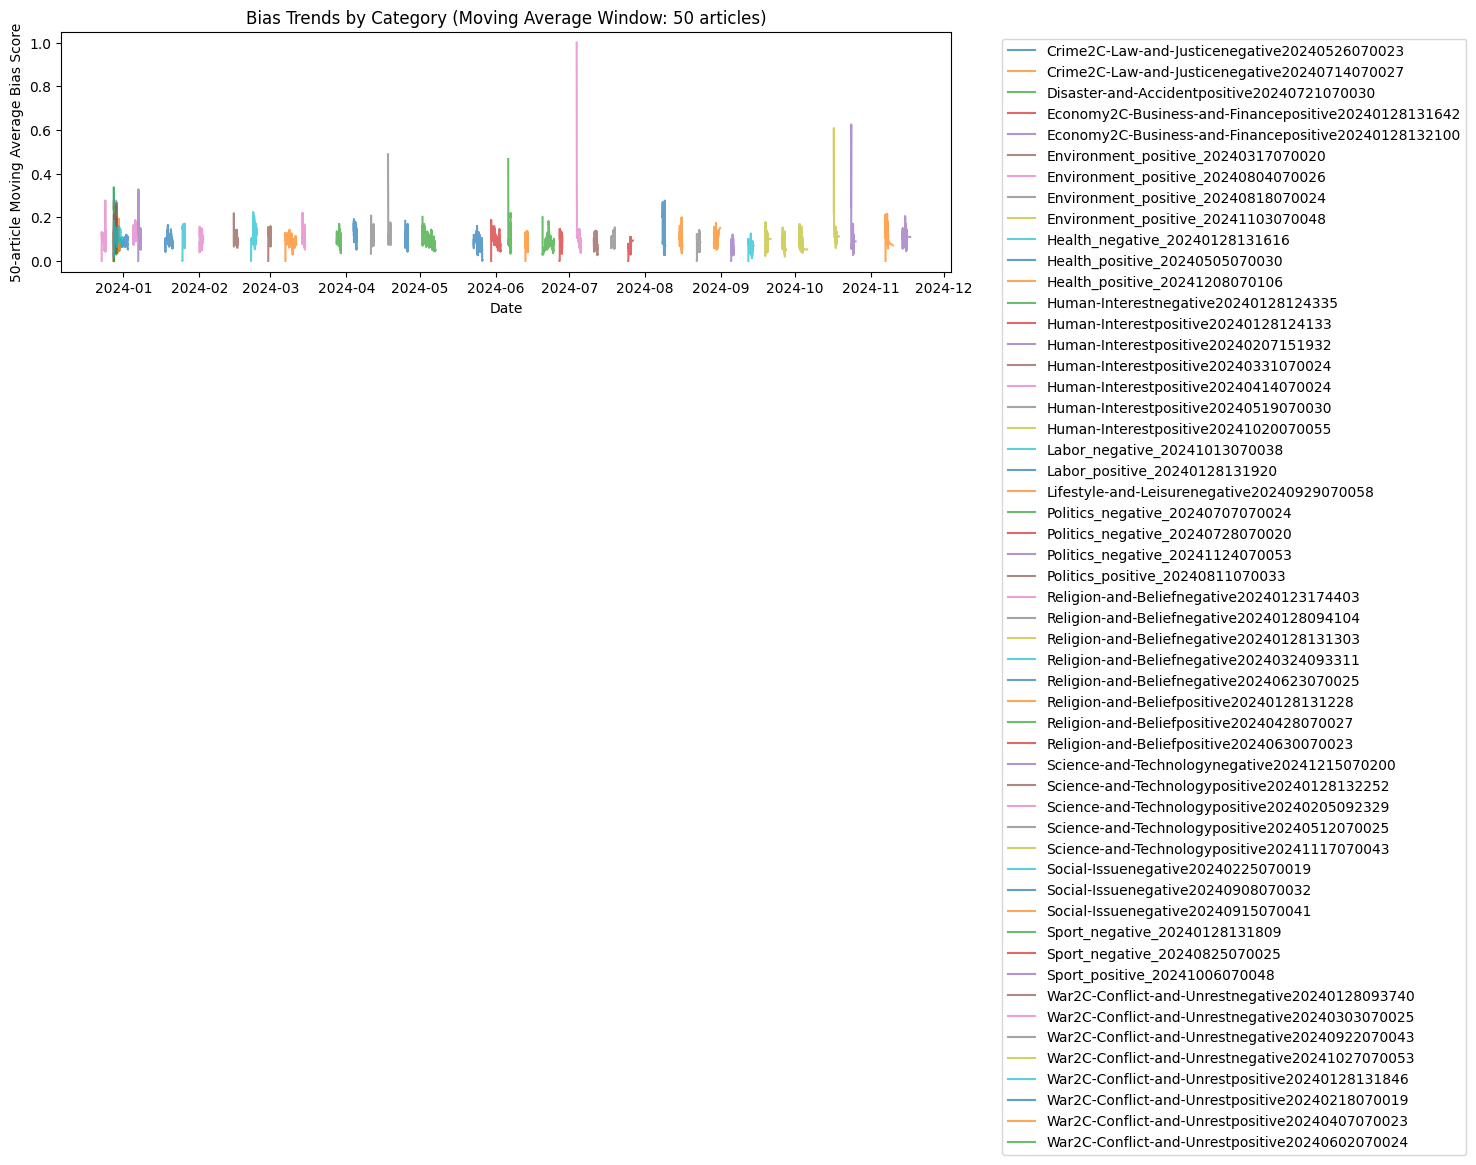


Generating interactive comparison...


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

class NewsCategoryAnalyzer:
    def __init__(self, df):
        self.df = df
        self.categories = df['category'].unique()

    # Inside the plot_bias_by_category method:
    def plot_bias_by_category(self):
        """Plot bias distribution across news categories"""
        plt.figure(figsize=(15, 8))

        # Create box plot of bias scores by category
        sns.boxplot(data=self.df, x='category', y='overall_bias_score')
        plt.xticks(rotation=45, ha='right')
        plt.title('Distribution of Bias Scores Across News Categories')
        plt.xlabel('News Category')
        plt.ylabel('Bias Score')
        plt.tight_layout()
        plt.show()

        # Print summary statistics
        stats_df = self.df.groupby('category')['overall_bias_score'].agg([
            'mean', 'std', 'count'
        ]).round(3)
        stats_df = stats_df.sort_values('mean', ascending=False)

        print("\nBias Statistics by Category:")
        print(stats_df)

        # Perform ANOVA test - Corrected version
        categories = list(self.df['category'].unique())
        bias_scores = [self.df[self.df['category'] == cat]['overall_bias_score'].values
                      for cat in categories]
        f_stat, p_value = stats.f_oneway(*bias_scores)
        print(f"\nANOVA Test Results:")
        print(f"F-statistic: {f_stat:.3f}")
        print(f"p-value: {p_value:.3f}")

    def plot_bias_prevalence(self):
        """Plot proportion of biased articles in each category"""
        # Calculate proportion of biased articles (bias score >= 0.3)
        bias_props = (self.df
                    .groupby('category')
                    .agg({
                        'overall_bias_score': lambda x: (x >= 0.3).mean(),
                        'text': 'count'
                    })
                    .reset_index())

        bias_props.columns = ['category', 'bias_proportion', 'total_articles']
        bias_props = bias_props.sort_values('bias_proportion', ascending=False)

        # Create figure with larger size and more bottom margin
        fig, ax1 = plt.subplots(figsize=(15, 10))  # Increased height

        # Plot bias proportion bars
        sns.barplot(data=bias_props, x='category', y='bias_proportion',
                  color='lightblue', ax=ax1)
        ax1.set_ylabel('Proportion of Biased Articles', fontsize=12)

        # Add article count line
        ax2 = ax1.twinx()
        ax2.plot(range(len(bias_props)), bias_props['total_articles'],
                color='red', marker='o', linewidth=2)
        ax2.set_ylabel('Total Articles', color='red', fontsize=12)

        # Set title with larger font
        plt.title('Bias Prevalence and Article Count by Category', fontsize=14, pad=20)

        # Rotate x-axis labels vertically with proper spacing
        ax1.set_xticklabels(bias_props['category'],
                            rotation=90,
                            ha='center',
                            fontsize=10)  # Increased font size

        # Add more space at the bottom for labels
        plt.subplots_adjust(bottom=0.2)  # Increased bottom margin

        # Add grid for better readability
        ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

        # Tight layout with specified padding
        plt.tight_layout(pad=2.0)  # Increased padding
        plt.show()

    def plot_category_heatmap(self):
        """Plot heatmap of bias types across categories"""
        # Get bias score columns
        bias_cols = [col for col in self.df.columns
                    if col.startswith('bias_score_')
                    and col != 'overall_bias_score']

        # Calculate mean bias scores for each category
        category_bias = (self.df
                        .groupby('category')[bias_cols]
                        .mean()
                        .round(3))

        plt.figure(figsize=(15, 10))
        sns.heatmap(category_bias, annot=True, cmap='YlOrRd', center=0.3)
        plt.title('Types of Bias Across News Categories')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def plot_bias_trends(self):
        """Plot bias trends over time for different categories"""
        if 'published' in self.df.columns:
            # Create a copy of the dataframe to avoid modifying the original
            plot_df = self.df.copy()

            # Convert to datetime and sort
            plot_df['date'] = pd.to_datetime(plot_df['published'])
            plot_df = plot_df.sort_values('date')

            plt.figure(figsize=(15, 8))

            # Define window size
            window_size = 50  # You can adjust this number

            for category in self.categories:
                cat_data = plot_df[plot_df['category'] == category]
                if len(cat_data) > 0:
                    # Calculate moving average using integer window
                    moving_avg = (cat_data
                                .set_index('date')['overall_bias_score']
                                .rolling(window=window_size, min_periods=1)
                                .mean()
                                .dropna())

                    if not moving_avg.empty:
                        plt.plot(moving_avg.index, moving_avg.values,
                                label=category, alpha=0.7)

            plt.title(f'Bias Trends by Category (Moving Average Window: {window_size} articles)')
            plt.xlabel('Date')
            plt.ylabel(f'{window_size}-article Moving Average Bias Score')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

    def plot_interactive_comparison(self):
        """Create interactive visualization comparing categories"""
        # Calculate summary statistics
        summary = (self.df
                  .groupby('category')
                  .agg({
                      'overall_bias_score': ['mean', 'std', 'count'],
                      'text': 'count'
                  })
                  .round(3))
        summary.columns = ['mean_bias', 'std_bias', 'biased_count', 'total_articles']
        summary = summary.reset_index()

        # Create interactive scatter plot
        fig = px.scatter(
            summary,
            x='mean_bias',
            y='total_articles',
            size='std_bias',
            color='category',
            hover_data=['biased_count'],
            title='Category Comparison: Bias vs. Article Count'
        )

        fig.show()

def main():
    # Load data
    df = pd.read_csv('articles_with_bias_scores.csv')

    # Create analyzer
    analyzer = NewsCategoryAnalyzer(df)

    # Generate all visualizations
    print("Generating bias distribution plot...")
    analyzer.plot_bias_by_category()

    print("\nGenerating bias prevalence plot...")
    analyzer.plot_bias_prevalence()

    print("\nGenerating category heatmap...")
    analyzer.plot_category_heatmap()

    print("\nGenerating bias trends plot...")
    analyzer.plot_bias_trends()

    print("\nGenerating interactive comparison...")
    analyzer.plot_interactive_comparison()

if __name__ == "__main__":
    main()

In [ ]:
import pickle
import json

# Save the JOURNALISM_BIAS_LEXICON
with open('bias_lexicon.json', 'w') as f:
    json.dump(JOURNALISM_BIAS_LEXICON, f)


